In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from pygraphs.measure import kernels
from pygraphs.scenario import d3_colors

In [4]:
kernel_ids = dict([(k.name, i) for i, k in enumerate(kernels)])
inverse_kernel_ids = list(kernel_ids.keys())
kernel_ids, inverse_kernel_ids

({'pWalk': 0,
  'Walk': 1,
  'For': 2,
  'logFor': 3,
  'Comm': 4,
  'logComm': 5,
  'Heat': 6,
  'logHeat': 7,
  'NHeat': 8,
  'logNHeat': 9,
  'SCT': 10,
  'SCCT': 11,
  'RSP': 12,
  'FE': 13,
  'PPR': 14,
  'logPPR': 15,
  'ModifPPR': 16,
  'logModifPPR': 17,
  'HeatPPR': 18,
  'logHeatPPR': 19,
  'SP-CT': 20},
 ['pWalk',
  'Walk',
  'For',
  'logFor',
  'Comm',
  'logComm',
  'Heat',
  'logHeat',
  'NHeat',
  'logNHeat',
  'SCT',
  'SCCT',
  'RSP',
  'FE',
  'PPR',
  'logPPR',
  'ModifPPR',
  'logModifPPR',
  'HeatPPR',
  'logHeatPPR',
  'SP-CT'])

In [5]:
with open('result.json') as f:
    overall_result = json.load(f)

In [6]:
np.sqrt(441)

21.0

In [7]:
best_measure, best_ari = np.full((21, 21), np.nan), np.full((21, 21), np.nan)
measure_counter = defaultdict(lambda: 0)
global_ratings = defaultdict(lambda: 0)
global_ratings_upper = defaultdict(lambda: 0)
global_ratings_lower = defaultdict(lambda: 0)
measure_ratings = np.full((21, 21, len(kernel_ids)), np.nan)
for pin_pout, cell_results in overall_result.items():
    pin, pout = pin_pout.split(', ')
    pin, pout = float(pin), float(pout)
    pin_idx, pout_idx = int(pin / 0.05), int(pout / 0.05)
    
    measure_best_ari = []
    for measure_name, measure_results in cell_results.items():
        if len(measure_results['ari']) > 0:
            best_ari_for_measure = np.nanmax(measure_results['ari'])
            measure_best_ari.append((measure_name, best_ari_for_measure))
    measure_best_ari = sorted(measure_best_ari, key=lambda x: x[1], reverse=True)
    
    for current_name, current_ari in measure_best_ari:
        better_than, worse_than = 0, 0
        for measure_name, measure_ari in measure_best_ari:
            if current_ari > measure_ari:
                better_than += 1
            if current_ari < measure_ari:
                worse_than += 1
        measure_ratings[pin_idx, pout_idx, kernel_ids[current_name]] = worse_than + 1
        if pin != pout:
            global_ratings[current_name] += better_than - worse_than
        if pin > pout:
            global_ratings_upper[current_name] += better_than - worse_than
        if pin < pout:
            global_ratings_lower[current_name] += better_than - worse_than
    
    if np.sum(np.array([x[1] for x in measure_best_ari]) == 1) < 2:
        best_measure[pin_idx, pout_idx] = kernel_ids[measure_best_ari[0][0]]
        best_ari[pin_idx, pout_idx] = measure_best_ari[0][1]
        measure_counter[measure_best_ari[0][0]] += 1

In [8]:
best_measure_color = np.zeros((21, 21, 3), dtype=np.uint8)
for i in range(21):
    for j in range(21):
        if not np.isnan(best_measure[i][j]):
            color = d3_colors[inverse_kernel_ids[int(best_measure[i][j])]]
            color = tuple(int(color[1:][i:i+2], 16) for i in (0, 2, 4))
            best_measure_color[i][j] = np.array(color)

In [9]:
p_ins = [f'{x:.2}' for x in np.arange(0, 1.0001, 0.1)]
p_outs = [f'{x:.2}' for x in np.arange(0, 1.0001, 0.1)]

In [10]:
colors_legend, names_legend = [], []
for measure_name in list(kernel_ids.keys()):
    color = d3_colors[measure_name]
    color = tuple(int(color[1:][i:i+2], 16) for i in (0, 2, 4))
    name = f'{measure_name} ({measure_counter[measure_name]})'
    colors_legend.append(color)
    names_legend.append(name)
colors_legend, names_legend = np.array(colors_legend), np.array(names_legend)

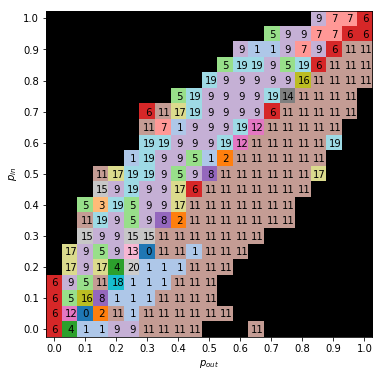

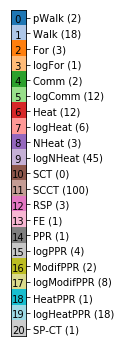

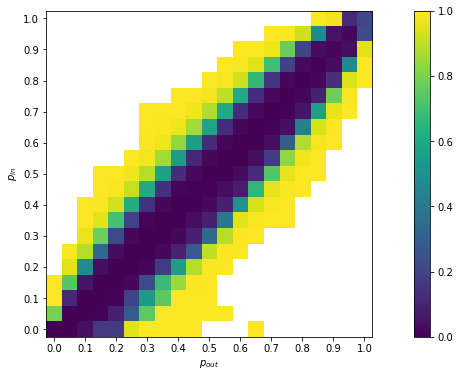

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.imshow(best_measure_color[::-1])
ax.set_yticks(range(0, len(p_ins)*2, 2))
ax.set_xticks(range(0, len(p_outs)*2, 2))
ax.set_yticklabels(p_ins[::-1])
ax.set_xticklabels(p_outs)
ax.set_ylabel('$p_{in}$')
ax.set_xlabel('$p_{out}$')

for i in range(21):
    for j in range(21):
        if not np.isnan(best_measure[i][j]):
            ax.text(j-0.29, 21-i-0.75, str(int(best_measure[i][j])).rjust(2))
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
            
ax.imshow(colors_legend[:, None, :])
ax.set_yticks(range(len(names_legend)))
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.yaxis.tick_right()
ax.set_yticklabels(names_legend);

for i in range(21):
    ax.text(-0.4, i+0.3, str(i).rjust(2))
    
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

a = ax.imshow(best_ari[::-1], vmin=0, vmax=1)
ax.set_yticks(range(0, len(p_ins)*2, 2))
ax.set_xticks(range(0, len(p_outs)*2, 2))
ax.set_yticklabels(p_ins[::-1])
ax.set_xticklabels(p_outs)
ax.set_ylabel('$p_{in}$')
ax.set_xlabel('$p_{out}$')
plt.colorbar(a)

In [12]:
sorted(global_ratings.items(), key=lambda x: x[1], reverse=True)

[('SCCT', 4513),
 ('Walk', 3858),
 ('logNHeat', 3514),
 ('logHeatPPR', 2999),
 ('logModifPPR', 2830),
 ('logPPR', 2691),
 ('logComm', 1601),
 ('logHeat', 1010),
 ('SP-CT', 436),
 ('Heat', 145),
 ('SCT', 104),
 ('RSP', 49),
 ('logFor', -927),
 ('FE', -1151),
 ('NHeat', -1766),
 ('HeatPPR', -2580),
 ('Comm', -2705),
 ('For', -3376),
 ('PPR', -3644),
 ('pWalk', -3778),
 ('ModifPPR', -3823)]

In [13]:
sorted(global_ratings_upper.items(), key=lambda x: x[1], reverse=True)

[('logNHeat', 2327),
 ('logHeatPPR', 2172),
 ('logComm', 1956),
 ('logModifPPR', 1903),
 ('logPPR', 1867),
 ('Walk', 1807),
 ('logHeat', 1655),
 ('SCCT', 1045),
 ('Heat', 981),
 ('logFor', 896),
 ('RSP', 252),
 ('SP-CT', 57),
 ('SCT', -183),
 ('FE', -412),
 ('Comm', -827),
 ('NHeat', -988),
 ('HeatPPR', -1806),
 ('ModifPPR', -2934),
 ('PPR', -3150),
 ('pWalk', -3172),
 ('For', -3446)]

In [14]:
sorted(global_ratings_lower.items(), key=lambda x: x[1], reverse=True)

[('SCCT', 3468),
 ('Walk', 2051),
 ('logNHeat', 1187),
 ('logModifPPR', 927),
 ('logHeatPPR', 827),
 ('logPPR', 824),
 ('SP-CT', 379),
 ('SCT', 287),
 ('For', 70),
 ('RSP', -203),
 ('logComm', -355),
 ('PPR', -494),
 ('pWalk', -606),
 ('logHeat', -645),
 ('FE', -739),
 ('HeatPPR', -774),
 ('NHeat', -778),
 ('Heat', -836),
 ('ModifPPR', -889),
 ('logFor', -1823),
 ('Comm', -1878)]

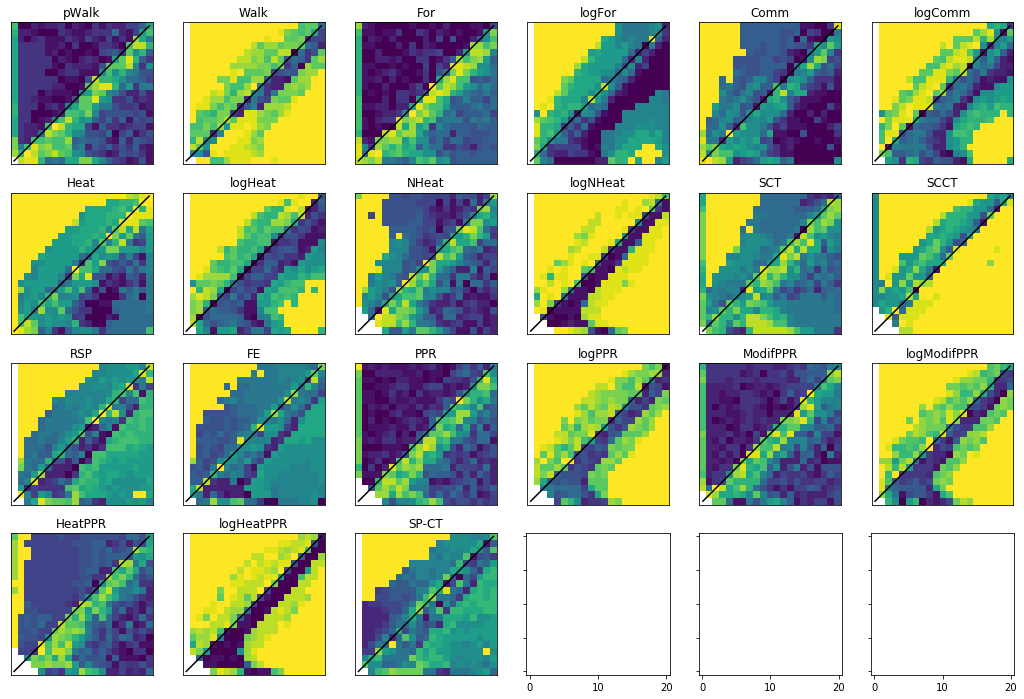

In [15]:
fig, ax = plt.subplots(4, 6, figsize=(18, 12), sharex=True, sharey=True)

for measure_name, measure_idx in kernel_ids.items():
    axi = ax[measure_idx // 6][measure_idx % 6]
    axi.imshow(measure_ratings[::-1, :, measure_idx], cmap='viridis_r')

    axi.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    axi.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
    
    axi.set_title(measure_name)
    
    axi.plot(range(21)[::-1], range(21), color='black')
    
#     for i in range(21):
#         for j in range(21):
#             a = measure_ratings[:, :, measure_idx][i, j]
#             if not np.isnan(a):
#                 text = str(int(a))
#                 axi.text(j-0.5, 21-i-0.65, text.rjust(2))

# Ranking